## Model Creation on Chunks

In [1]:
train_len = 295246830
one_len = 1589906
zero_len = 293656924
protein_map = {'BRD4': 1, 'HSA': 2, 'sEH': 3}
vocab = {'C': 6825082866, '#': 81527490, '@': 511451694, 'H': 456489972, '=': 1406606874, 'O': 2554179786,
         'N': 2469595230, 'c': 12257477022, '-': 438483636, '.': 216945504, 'l': 491088828, 'B': 123330132,
         'r': 121915914, 'n': 1997759694, 'D': 295246830, 'y': 295246830, 'o': 67918650, 's': 156618468,
         'S': 90662574, 'F': 492710238, '+': 65206260, 'i': 1414026, '/': 11547096, 'I': 23972994}

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql.types import LongType, IntegerType, StructType, StructField

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from xgboost.spark import SparkXGBClassifier

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

In [3]:
import pyspark
pyspark.__version__

'3.5.3'

In [4]:
# for 256 Gb and 64 Cores
# spark = (
#     SparkSession
#     .builder
#     .appName("leash belka3")
#     .config("spark.driver.memory", "48g")  # Increased driver memory
#     .config("spark.executor.memory", "48g")  # Increased executor memory
#     .config("spark.executor.instances", "16")  # 16 executors
#     .config("spark.executor.cores", "4")  # 4 cores per executor
#     .config("spark.driver.maxResultSize", "4g")  # Driver result size limit
#     .config("spark.local.dir", "temp")  # Specify a directory with enough space
#     .config("spark.shuffle.file.buffer", "128k")  # Shuffle buffer size
#     .config("spark.memory.fraction", "0.8")  # Memory fraction for tasks
#     .config("spark.shuffle.memoryFraction", "0.6")  # Shuffle memory fraction
#     .config("spark.executor.javaOptions", "-Xmx48g")  # JVM heap size for executors
#     .master("local[64]")  # Use all 64 cores on the machine
#     .getOrCreate()
# )

# spark

# SynapseML 
spark = (
    SparkSession
    .builder
    .appName("leash belka3")
    .config("spark.driver.memory", "48g")  # Increased driver memory
    .config("spark.executor.memory", "48g")  # Increased executor memory
    .config("spark.executor.instances", "16")  # 16 executors
    .config("spark.executor.cores", "4")  # 4 cores per executor
    .config("spark.driver.maxResultSize", "4g")  # Driver result size limit
    .config("spark.local.dir", "temp")  # Specify a directory with enough space
    .config("spark.shuffle.file.buffer", "128k")  # Shuffle buffer size
    .config("spark.memory.fraction", "0.8")  # Memory fraction for tasks
    .config("spark.shuffle.memoryFraction", "0.6")  # Shuffle memory fraction
    .config("spark.executor.javaOptions", "-Xmx48g")  # JVM heap size for executors
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.8")
    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven")
    .master("local[64]")  # Use all 64 cores on the machine
    .getOrCreate()
)

spark

# spark = (
#     SparkSession
#     .builder
#     .appName("leash belka3")
#     .config("spark.driver.memory", "64g")  # Increased driver memory
#     .config("spark.executor.memory", "64g")  # Increased executor memory
#     .config("spark.executor.instances", "8")  # Reduced number of executors
#     .config("spark.executor.cores", "8")  # Increased cores per executor
#     .config("spark.driver.maxResultSize", "4g")  # Driver result size limit
#     .config("spark.local.dir", "temp")  # Specify a directory with enough space
#     .config("spark.shuffle.file.buffer", "128k")  # Shuffle buffer size
#     .config("spark.memory.fraction", "0.8")  # Memory fraction for tasks
#     .config("spark.shuffle.memoryFraction", "0.7")  # Shuffle memory fraction
#     .config("spark.executor.javaOptions", "-Xmx64g")  # JVM heap size for executors
#     .config("spark.sql.shuffle.partitions", "1000")  # Increase shuffle partitions
#     .config("spark.ui.enabled", "true")  # Enable Spark UI
#     .master("local[8]")  # Reduced number of cores for local mode
#     .getOrCreate()
# )

# spark


24/12/26 14:59:17 WARN Utils: Your hostname, kanjur resolves to a loopback address: 127.0.1.1; using 10.119.2.14 instead (on interface eno3)
24/12/26 14:59:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1


:: loading settings :: url = jar:file:/home/23m1521/.conda/envs/cuda_env2/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/23m1521/.ivy2/cache
The jars for the packages stored in: /home/23m1521/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-40934ccb-8254-4813-a0f5-747e1d6a06b5;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;1.0.8 in repo-1
	found com.microsoft.azure#synapseml-core_2.12;1.0.8 in central
	found org.apache.spark#spark-avro_2.12;3.4.1 in central
	found org.tukaani#xz;1.9 in central
	found commons-lang#commons-lang;2.6 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in

In [6]:
df0_features = spark.read.format('parquet').load('zero_features.parquet')
df1_features = spark.read.format('parquet').load('one_features.parquet')

full_df = df0_features.union(df1_features).orderBy(F.rand())

# print(df0_features.rdd.getNumPartitions())
# print(full_df.count())
# df0_features.printSchema()

In [7]:
# sample_df = full_df.sample(fraction=0.00001)

In [8]:
from pyspark.ml.feature import OneHotEncoder

protein_ohe = OneHotEncoder(inputCol="protein", outputCol="protein_onehot")
protein_ohe = protein_ohe.fit(full_df)

In [9]:
full_df = protein_ohe.transform(full_df)

In [10]:
features_cols = full_df.columns[-1:] + full_df.columns[2:-2]

In [11]:
vectorAssembler = VectorAssembler(inputCols=features_cols, outputCol='features')

In [12]:
full_df2 = vectorAssembler.transform(full_df)

In [ ]:
print(full_df2.rdd.getNumPartitions())

In [10]:
full_df2 = full_df2.repartition(500)

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [16]:
# model = SparkXGBClassifier(num_workers=spark.sparkContext.defaultParallelism, label_col='y')

xgb_classifier = SparkXGBClassifier(
    label_col="y", 
    features_col="features", 
    num_workers=spark.sparkContext.defaultParallelism,
    # use_gpu=True,
    # device='cuda',
    max_depth=6
)

In [11]:
xgb_model = xgb_classifier.fit(full_df2)

2024-12-25 03:01:57,805 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 64 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-25 03:38:42,074 INFO XGBoost-PySpark: _train_booster Training on CPUs64]
[03:38:44] Task 24 got rank 17
[03:38:45] Task 26 got rank 19[03:38:45] Task 25 got rank 18

[03:38:45] Task 27 got rank 20
[03:38:45] Task 21 got rank 14
[03:38:46] Task 0 got rank 0
[03:38:46] Task 23 got rank 16
[03:38:46] Task 2 got rank 12
[03:38:46] Task 17 got rank 9
[03:38:46] Task 19 got rank 11
[03:38:46] Task 12 got rank 4
[03:38:46] Task 1 got rank 1
[03:38:46] Task 15 got rank 7
[03:38:46] Task 18 got rank 10
[03:38:46] Task 10 got rank 2
[03:38:47] Task 28 got rank 21
[03:38:47] Task 3 got rank 23
[03:38:47] Task 29 got rank 22
[03:38:47] Task 33 got rank 27
[03:38:47] Task 30 got rank 2

In [12]:
model_path = "checkpoints/_1_XGB"
xgb_model.save(model_path)

In [20]:
model_checkpoint_path = "checkpoints/_1_XGB"
from xgboost.spark import SparkXGBClassifierModel
xgb_model = SparkXGBClassifierModel.load(model_checkpoint_path)

In [23]:
predictions = xgb_model.transform(full_df2)

In [24]:
predictions_with_prob = predictions.select("features", "y", "prediction", "probability")
predictions_with_prob.show()

24/12/25 22:43:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
2024-12-25 22:51:27,678 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+--------------------+---+----------+--------------------+
|            features|  y|prediction|         probability|
+--------------------+---+----------+--------------------+
|(99,[1,3,4,5,6,7,...|  0|       0.0|[0.99876505136489...|
|(99,[3,4,6,11,14,...|  0|       0.0|[0.99735057353973...|
|(99,[3,4,5,6,19,2...|  0|       0.0|[0.99631875753402...|
|(99,[1,3,4,5,6,19...|  0|       0.0|[0.99981039762496...|
|(99,[2,3,4,5,6,11...|  0|       0.0|[0.99912452697753...|
|(99,[1,3,4,5,6,9,...|  0|       0.0|[0.99519944190979...|
|(99,[1,3,4,5,6,19...|  0|       0.0|[0.99969738721847...|
|(99,[3,4,5,6,9,10...|  0|       0.0|[0.99960231781005...|
|(99,[1,3,4,5,6,19...|  0|       0.0|[0.99991178512573...|
|(99,[1,3,4,5,6,17...|  0|       0.0|[0.99906617403030...|
|(99,[3,4,5,6,16,1...|  0|       0.0|[0.99967205524444...|
|(99,[1,3,4,5,6,13...|  0|       0.0|[0.99878025054931...|
|(99,[2,3,4,5,6,8,...|  0|       0.0|[0.98578625917434...|
|(99,[2,3,4,5,6,19...|  0|       0.0|[0.99948269128799..

In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Calculate Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="y", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions_with_prob)
print(f"Accuracy: {accuracy}")

2024-12-25 04:46:59,107 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
[Stage 39:=====================================================>(199 + 1) / 200]

Accuracy: 0.9947953073704466


In [28]:
# Calculate AUC (Area Under ROC)
auc_evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = auc_evaluator.evaluate(predictions_with_prob)
print(f"AUC: {auc}")

2024-12-25 15:02:59,189 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
                                                                                

AUC: 0.5488251045082845


In [25]:
# Calculate PR AUC (Area Under Precision-Recall Curve)
pr_auc_evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName="areaUnderPR")
pr_auc = pr_auc_evaluator.evaluate(predictions_with_prob)
print(f"PR AUC (approx MAP): {pr_auc}")

2024-12-25 23:00:44,308 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
                                                                                

PR AUC (approx MAP): 0.33348622180529797


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql import functions as F

# Calculate the precision for the binary classification task manually
# First, calculate the confusion matrix components (TP, FP, TN, FN)

# True Positives, False Positives, True Negatives, False Negatives
TP = predictions_with_prob.filter((col("y") == 1) & (col("prediction") == 1)).count()
FP = predictions_with_prob.filter((col("y") == 0) & (col("prediction") == 1)).count()
TN = predictions_with_prob.filter((col("y") == 0) & (col("prediction") == 0)).count()
FN = predictions_with_prob.filter((col("y") == 1) & (col("prediction") == 0)).count()

# Calculate Precision (TP / (TP + FP))
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Print Precision
print(f"Precision: {precision}")

# Now, calculate Weighted Precision
# Count total instances per class to compute weighted precision
class_counts = predictions_with_prob.groupBy("y").count()

# Get the total number of instances
total_instances = predictions_with_prob.count()

# Compute precision per class and weight them by class frequency
weighted_precision = 0
for row in class_counts.collect():
    label = row["y"]
    class_count = row["count"]
    
    # Calculate precision for each class (you can define per-class precision as needed)
    if label == 1:
        # Precision for class 1 (positive class)
        precision_class = TP / (TP + FP) if (TP + FP) > 0 else 0
    else:
        # Precision for class 0 (negative class)
        precision_class = TN / (TN + FN) if (TN + FN) > 0 else 0
    
    # Calculate the weight for the class
    weight = class_count / total_instances
    
    # Update weighted precision
    weighted_precision += precision_class * weight

print(f"Weighted Precision: {weighted_precision}")

In [32]:
weighted_precision

0.9930269044411657

155810 102573 293554351 1434096


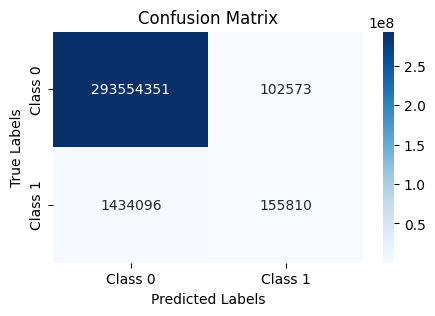

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

print(TP, FP, TN, FN)
confusion_matrix = [
    [TN, FP],
    [FN, TP]
]

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [60]:
(100*155810)/(155810+1434096), (100*1434096)/(155810+1434096)

(9.799950437321451, 90.20004956267854)

In [56]:
# Calculate Precision and Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Precision = TP / (TP + FP)
recall = TP / (TP + FN) if (TP + FN) > 0 else 0      # Recall = TP / (TP + FN)

precision, recall

(0.6030195484997078, 0.09799950437321452)

In [ ]:
'''
To calculate Mean Average Precision (mAP), you need to use the precision at 
different recall levels. The formula for Average Precision (AP) for each class 
is the area under the Precision-Recall Curve, which involves precision and 
recall values calculated at multiple thresholds.
'''
'''
In a binary classification task, the mAP is equivalent to the AP since you 
only have one class. In a multi-class or multi-label task, you would compute 
the AP for each class and then average them to get the mAP.
'''
# Calculate Average Precision (AP) for binary classification
# AP is calculated as the area under the precision-recall curve
# Here we are assuming precision and recall are given as single values, 
# but you can extend this by calculating precision and recall at multiple thresholds

# Create precision-recall curve data (in a real case, you would get this from a classifier)
# Assuming we are working with a single class, and you have precision and recall values at different thresholds.
precisions = [0.9, 0.8, 0.7]  # Example precision values at different thresholds
recalls = [0.1, 0.5, 1.0]    # Example recall values at different thresholds

# Calculate Average Precision (AP) using precision-recall pairs
ap = 0
for i in range(1, len(precisions)):
    recall_diff = recalls[i] - recalls[i - 1]
    ap += precisions[i] * recall_diff

# Calculate mAP (For multi-class, you'd compute AP for each class and then average them)
mAP = ap  # In this case, mAP is equal to AP as it's binary classification
print(f"Mean Average Precision (mAP): {mAP}")

## Test Inference

In [26]:
test_df = spark.read.format('parquet').load('test_features.parquet')
test_df = protein_ohe.transform(test_df)
test_df2 = vectorAssembler.transform(test_df)
test_predictions = xgb_model.transform(test_df2)
test_predictions_with_prob = test_predictions.select("features", "y", "prediction", "probability")
test_predictions_with_prob.show()

2024-12-25 23:44:24,155 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
[Stage 40:==========================================================(4 + 0) / 4]

+--------------------+---+----------+--------------------+
|            features|  y|prediction|         probability|
+--------------------+---+----------+--------------------+
|(99,[1,3,4,5,6,7,...|  2|       0.0|[0.99720060825347...|
|(99,[2,3,4,5,6,7,...|  2|       0.0|[0.71769237518310...|
|(99,[3,4,5,6,7,10...|  2|       0.0|[0.99608540534973...|
|(99,[1,3,4,5,6,7,...|  2|       0.0|[0.99871140718460...|
|(99,[2,3,4,5,6,7,...|  2|       0.0|[0.99597078561782...|
|(99,[3,4,5,6,7,10...|  2|       0.0|[0.99902218580245...|
|(99,[1,3,4,5,6,7,...|  2|       0.0|[0.99875897169113...|
|(99,[2,3,4,5,6,7,...|  2|       0.0|[0.99942106008529...|
|(99,[3,4,5,6,7,10...|  2|       0.0|[0.99850010871887...|
|(99,[1,3,4,5,6,7,...|  2|       0.0|[0.99829071760177...|
|(99,[2,3,4,5,6,7,...|  2|       0.0|[0.99590224027633...|
|(99,[3,4,5,6,7,10...|  2|       0.0|[0.99841290712356...|
|(99,[1,3,4,5,6,7,...|  2|       0.0|[0.99915039539337...|
|(99,[2,3,4,5,6,7,...|  2|       0.0|[0.99930113554000..

In [42]:
test_prob = np.array(test_predictions_with_prob.select('probability').collect()).reshape(-1,2)[:,1]

2024-12-25 23:54:32,247 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
                                                                                

In [43]:
test_prob

array([0.00279941, 0.28230765, 0.00391461, ..., 0.00182203, 0.00232565,
       0.00161004])

In [50]:
np.unique(np.array(test_predictions_with_prob.select('prediction').collect()), return_counts=True)

2024-12-25 23:59:20,489 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
                                                                                

(array([0., 1.]), array([1672597,    2299]))

In [44]:
import pandas as pd
import numpy as np

In [45]:
sub_df = pd.read_csv('sample_submission.csv.zip')
sub_df

,id,binds
0,295246830,0.5
1,295246831,0.5
2,295246832,0.5
3,295246833,0.5
4,295246834,0.5
...,...,...
1674891,296921721,0.5
1674892,296921722,0.5
1674893,296921723,0.5
1674894,296921724,0.5


In [46]:
sub_df.binds = test_prob
sub_df

,id,binds
0,295246830,0.002799
1,295246831,0.282308
2,295246832,0.003915
3,295246833,0.001289
4,295246834,0.004029
...,...,...
1674891,296921721,0.000432
1674892,296921722,0.001171
1674893,296921723,0.001822
1674894,296921724,0.002326


In [52]:
import subprocess, os

file_name = f"submission_csv/_2_submission_PySpark_XGB.csv"
message = f"PySpark XGB"
os.makedirs("submission_csv", exist_ok=True)

sub_df.to_csv(file_name, index=False)
display(pd.read_csv(file_name))

command = [
    "kaggle", "competitions", "submit",
    "-c", "leash-BELKA",
    "-f", file_name,
    "-m", message
]

subprocess.run(command)

,id,binds
0,295246830,0.002799
1,295246831,0.282308
2,295246832,0.003915
3,295246833,0.001289
4,295246834,0.004029
...,...,...
1674891,296921721,0.000432
1674892,296921722,0.001171
1674893,296921723,0.001822
1674894,296921724,0.002326


100%|██████████| 50.7M/50.7M [00:16<00:00, 3.31MB/s]  


Successfully submitted to NeurIPS 2024 - Predict New Medicines with BELKA

CompletedProcess(args=['kaggle', 'competitions', 'submit', '-c', 'leash-BELKA', '-f', 'submission_csv/_2_submission_PySpark_XGB.csv', '-m', 'PySpark XGB'], returncode=0)

24/12/26 00:12:39 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /home/23m1521/ashish/kaggle/temp/blockmgr-3fc138e1-0b9b-4f5a-9741-b961499799a1. Falling back to Java IO way
java.io.IOException: Failed to delete: /home/23m1521/ashish/kaggle/temp/blockmgr-3fc138e1-0b9b-4f5a-9741-b961499799a1
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:174)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:109)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:90)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1126)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:368)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockMa

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

xgb_classifier = SparkXGBClassifier(label_col="y", features_col="features")
evaluator = BinaryClassificationEvaluator(labelCol="y", metricName="areaUnderPR")

param_grid = ParamGridBuilder() \
    .addGrid(xgb_classifier.max_depth, [3, 5, 7, 10]) \
    .addGrid(xgb_classifier.learning_rate , [0.01, 0.1, 0.2, 0.3]) \
    .addGrid(xgb_classifier.subsample, [0.6, 0.8, 1.0]) \
    .addGrid(xgb_classifier.colsample_bytree, [0.6, 0.8, 1.0]) \
    .addGrid(xgb_classifier.gamma, [0, 0.1, 0.2, 0.5]) \
    .addGrid(xgb_classifier.min_child_weight, [1, 3, 5]) \
    .addGrid(xgb_classifier.reg_lambda, [0, 1, 5]) \
    .addGrid(xgb_classifier.reg_alpha, [0, 1, 5]) \
    .addGrid(xgb_classifier.n_estimators, [3000]) \
    .build()

crossval = CrossValidator(estimator=xgb_classifier,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

cv_model = crossval.fit(full_df2)

best_model = cv_model.bestModel
model_path = "checkpoints/_2_XGB_CV"
best_model.save(best_model_path)

predictions = best_model.transform(full_df2)

aucPR = evaluator.evaluate(predictions)
print(f"Test AUC-PR: {aucPR}")

best_params = cv_model.bestModel.extractParamMap()
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

24/12/26 05:30:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/26 06:33:17 WARN MemoryStore: Not enough space to cache rdd_44_171 in memory! (computed 44.7 MiB so far)
24/12/26 06:33:17 WARN BlockManager: Persisting block rdd_44_171 to disk instead.
24/12/26 06:33:17 WARN MemoryStore: Not enough space to cache rdd_44_139 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:17 WARN BlockManager: Persisting block rdd_44_139 to disk instead.
24/12/26 06:33:18 WARN MemoryStore: Not enough space to cache rdd_44_141 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:18 WARN BlockManager: Persisting block rdd_44_141 to disk instead.
24/12/26 06:33:18 WARN MemoryStore: Not enough space to cache rdd_44_173 in memory! (computed 44.7 MiB so far)
24/12/26 06:33:18 WARN BlockManager: Persisting block rdd_44_173 to disk instead.
24/12/26 06:33:18 WARN MemoryStore: Not

[3980.477s][warning][gc,alloc] Executor task launch worker for task 185.0 in stage 13.0 (TID 920): Retried waiting for GCLocker too often allocating 76014 words
[3980.485s][warning][gc,alloc] Executor task launch worker for task 137.0 in stage 13.0 (TID 872): Retried waiting for GCLocker too often allocating 104891 words
[3980.485s][warning][gc,alloc] Spark Context Cleaner: Retried waiting for GCLocker too often allocating 331 words
[3980.494s][warning][gc,alloc] Executor task launch worker for task 165.0 in stage 13.0 (TID 900): Retried waiting for GCLocker too often allocating 57427 words
[3980.515s][warning][gc,alloc] Executor task launch worker for task 134.0 in stage 13.0 (TID 869): Retried waiting for GCLocker too often allocating 107590 words


24/12/26 06:33:27 WARN MemoryStore: Not enough space to cache rdd_44_190 in memory! (computed 44.7 MiB so far)
24/12/26 06:33:27 WARN BlockManager: Persisting block rdd_44_190 to disk instead.
24/12/26 06:33:27 WARN MemoryStore: Not enough space to cache rdd_44_158 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:27 WARN BlockManager: Persisting block rdd_44_158 to disk instead.


[3980.892s][warning][gc,alloc] Executor task launch worker for task 130.0 in stage 13.0 (TID 865): Retried waiting for GCLocker too often allocating 115185 words


24/12/26 06:33:29 WARN MemoryStore: Not enough space to cache rdd_44_162 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:29 WARN BlockManager: Persisting block rdd_44_162 to disk instead.
24/12/26 06:33:29 WARN MemoryStore: Not enough space to cache rdd_44_163 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:29 WARN BlockManager: Persisting block rdd_44_163 to disk instead.
24/12/26 06:33:30 WARN MemoryStore: Not enough space to cache rdd_44_168 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:30 WARN BlockManager: Persisting block rdd_44_168 to disk instead.
24/12/26 06:33:30 WARN MemoryStore: Not enough space to cache rdd_44_166 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:30 WARN BlockManager: Persisting block rdd_44_166 to disk instead.
24/12/26 06:33:30 WARN MemoryStore: Not enough space to cache rdd_44_167 in memory! (computed 86.8 MiB so far)
24/12/26 06:33:30 WARN BlockManager: Persisting block rdd_44_167 to disk instead.
24/12/26 06:33:38 WARN MemoryStore:

[3994.854s][warning][gc,alloc] Executor task launch worker for task 172.0 in stage 13.0 (TID 907): Retried waiting for GCLocker too often allocating 96676 words
[3994.855s][warning][gc,alloc] Executor task launch worker for task 163.0 in stage 13.0 (TID 898): Retried waiting for GCLocker too often allocating 87102 words
[3994.855s][warning][gc,alloc] Executor task launch worker for task 148.0 in stage 13.0 (TID 883): Retried waiting for GCLocker too often allocating 105646 words
[3994.855s][warning][gc,alloc] Executor task launch worker for task 154.0 in stage 13.0 (TID 889): Retried waiting for GCLocker too often allocating 92596 words
[3994.865s][warning][gc,alloc] Executor task launch worker for task 159.0 in stage 13.0 (TID 894): Retried waiting for GCLocker too often allocating 98146 words
[3994.865s][warning][gc,alloc] Executor task launch worker for task 131.0 in stage 13.0 (TID 866): Retried waiting for GCLocker too often allocating 95239 words
[3994.865s][warning][gc,alloc] Ex

24/12/26 06:33:41 WARN BlockManager: Block rdd_44_152 could not be removed as it was not found on disk or in memory
24/12/26 06:33:41 ERROR Executor: Exception in task 152.0 in stage 13.0 (TID 887)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:64)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:363)
	at org.apache.spark.sql.execution.columnar.BasicColumnBuilder.initialize(ColumnBuilder.scala:68)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.org$apache$spark$sql$execution$columnar$NullableColumnBuilder$$super$initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize(NullableColumnBuilder.scala:51)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize$(NullableColumnBuilder.scala:42)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.org$apache$spark$sql$execution$columnar$compression$CompressibleColumnBuilde

Py4JJavaError: An error occurred while calling o3975.javaToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 152 in stage 13.0 failed 1 times, most recent failure: Lost task 152.0 in stage 13.0 (TID 887) (kanjur.ieor.iitb.ac.in executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:64)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:363)
	at org.apache.spark.sql.execution.columnar.BasicColumnBuilder.initialize(ColumnBuilder.scala:68)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.org$apache$spark$sql$execution$columnar$NullableColumnBuilder$$super$initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize(NullableColumnBuilder.scala:51)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize$(NullableColumnBuilder.scala:42)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.org$apache$spark$sql$execution$columnar$compression$CompressibleColumnBuilder$$super$initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.compression.CompressibleColumnBuilder.initialize(CompressibleColumnBuilder.scala:62)
	at org.apache.spark.sql.execution.columnar.compression.CompressibleColumnBuilder.initialize$(CompressibleColumnBuilder.scala:51)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.ColumnBuilder$.apply(ColumnBuilder.scala:203)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.$anonfun$next$1(InMemoryRelation.scala:83)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1$$Lambda$6859/0x00007fe5413e6f80.apply(Unknown Source)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.TraversableLike$$Lambda$159/0x00007fe540217240.apply(Unknown Source)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:82)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:80)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.next(InMemoryRelation.scala:290)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.next(InMemoryRelation.scala:287)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:224)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1597)
	at org.apache.spark.storage.BlockManager$$Lambda$1506/0x00007fe5408d2050.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:64)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:363)
	at org.apache.spark.sql.execution.columnar.BasicColumnBuilder.initialize(ColumnBuilder.scala:68)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.org$apache$spark$sql$execution$columnar$NullableColumnBuilder$$super$initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize(NullableColumnBuilder.scala:51)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize$(NullableColumnBuilder.scala:42)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.org$apache$spark$sql$execution$columnar$compression$CompressibleColumnBuilder$$super$initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.compression.CompressibleColumnBuilder.initialize(CompressibleColumnBuilder.scala:62)
	at org.apache.spark.sql.execution.columnar.compression.CompressibleColumnBuilder.initialize$(CompressibleColumnBuilder.scala:51)
	at org.apache.spark.sql.execution.columnar.NativeColumnBuilder.initialize(ColumnBuilder.scala:99)
	at org.apache.spark.sql.execution.columnar.ColumnBuilder$.apply(ColumnBuilder.scala:203)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.$anonfun$next$1(InMemoryRelation.scala:83)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1$$Lambda$6859/0x00007fe5413e6f80.apply(Unknown Source)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.TraversableLike$$Lambda$159/0x00007fe540217240.apply(Unknown Source)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:82)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:80)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.next(InMemoryRelation.scala:290)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.next(InMemoryRelation.scala:287)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:224)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1597)
	at org.apache.spark.storage.BlockManager$$Lambda$1506/0x00007fe5408d2050.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)


24/12/26 06:34:11 WARN ShutdownHookManager: ShutdownHook '' timeout, java.util.concurrent.TimeoutException
java.util.concurrent.TimeoutException
	at java.base/java.util.concurrent.FutureTask.get(FutureTask.java:204)
	at org.apache.hadoop.util.ShutdownHookManager.executeShutdown(ShutdownHookManager.java:124)
	at org.apache.hadoop.util.ShutdownHookManager$1.run(ShutdownHookManager.java:95)
24/12/26 06:34:11 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /home/23m1521/ashish/kaggle/temp/blockmgr-d454b1a4-d4b7-4a85-b2aa-db18a5627146. Falling back to Java IO way
java.io.IOException: Failed to delete: /home/23m1521/ashish/kaggle/temp/blockmgr-d454b1a4-d4b7-4a85-b2aa-db18a5627146
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:166)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:109)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:90)
	at org.apache.spark.uti

//////////////////////////////////////////////////////////////////////////////////////////////

## SynapseML LightGBMClassifier

In [13]:
from synapse.ml.lightgbm import LightGBMClassifier

model = LightGBMClassifier(
    objective="binary", featuresCol="features", labelCol="y", isUnbalance=True
)
model

LightGBMClassifier_1f23f41e6e02

In [14]:
model = model.fit(full_df2)

24/12/26 15:30:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Saving data reference to binary buffer


[Stage 27:>                                                       (0 + 64) / 64]

[LightGBM] [Info] Loaded reference dataset: 81 features, 295246830 num_data
[thread 96929 also had an error][thread 97038 also had an error]
[thread 98010 also had an error]

[thread 97977 also had an error][thread 97455 also had an error][thread 97145 also had an error][thread 97088 also had an error]

[thread 97973 also had an error]


[thread 97545 also had an error]
[thread 96071 also had an error]
[thread 97189 also had an error][thread 97978 also had an error][thread 98109 also had an error][thread 97037 also had an error][thread 97713 also had an error][thread 96867 also had an error]
[thread 96779 also had an error]

[thread 97147 also had an error]

[thread 97976 also had an error]


[thread 96930 also had an error]
[thread 97972 also had an error]

[thread 97330 also had an error]
[thread 97975 also had an error][thread 97296 also had an error]

#
# A fatal error has been detected by the Java Runtime Environment:
#
#  SIGSEGV (0xb) at pc=0x00007f57969acac3, pid=92861, tid=978

terminate called without an active exception
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/23m1521/.conda/envs/cuda_env2/lib/python3.12/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/23m1521/.conda/envs/cuda_env2/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/23m1521/.conda/envs/cuda_env2/lib/python3.12/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: An error occurred while calling o124.fit

In [18]:
from synapse.ml.lightgbm import LightGBMClassificationModel
from synapse.ml.core.platform import *

if running_on_synapse():
    print('running_on_synapse')
    # model.saveNativeModel("checkpoints/lgbmclassifier.model")
    # model = LightGBMClassificationModel.loadNativeModelFromFile("/models/lgbmclassifier.model")
if running_on_synapse_internal():
    print('running_on_synapse_internal')
    # model.saveNativeModel("checkpoints/lgbmclassifier.model")
    # model = LightGBMClassificationModel.loadNativeModelFromFile("Files/models/lgbmclassifier.model")
else:
    print('else')
    model.saveNativeModel("checkpoints/lgbmclassifier.model")
    # model = LightGBMClassificationModel.loadNativeModelFromFile("/tmp/lgbmclassifier.model")

else


AttributeError: 'LightGBMClassifier' object has no attribute 'saveNativeModel'

In [16]:
train_predictions = model.transform(test_df2)
train_predictions_with_prob = train_predictions.select("features", "y", "prediction", "probability")
train_predictions_with_prob.show()

AttributeError: 'LightGBMClassifier' object has no attribute 'transform'

In [ ]:
from synapse.ml.train import ComputeModelStatistics

scores = ComputeModelStatistics(
    evaluationMetric="classification",
    labelCol="y",
    scoredLabelsCol="prediction"
).transform(train_predictions_with_prob).collect()[0].asDict()
display(metrics)

In [ ]:
test_df = spark.read.format('parquet').load('test_features.parquet')
test_df = protein_ohe.transform(test_df)
test_df2 = vectorAssembler.transform(test_df)
test_predictions = model.transform(test_df2)
test_predictions_with_prob = test_predictions.select("features", "y", "prediction", "probability")
test_predictions_with_prob.show()

In [ ]:
from synapse.ml.train import ComputeModelStatistics

scores = ComputeModelStatistics(
    evaluationMetric="classification",
    labelCol="y",
    scoredLabelsCol="prediction"
).transform(test_predictions_with_prob).collect()[0].asDict()
display(metrics)

# SynapseML Hyperopt HPS for LightGBMClassifier

In [ ]:
train_data, validation_data = full_df2.randomSplit([0.85, 0.15], seed=42)

In [ ]:
from synapse.ml.lightgbm import LightGBMClassifier
from synapse.ml.train import ComputeModelStatistics


def train_tree(alpha, learningRate, numLeaves, numIterations):

    lgc = LightGBMClassifier(
        objective="binary",
        featuresCol="features",
        labelCol="y",
        isUnbalance=True,
        
        alpha=alpha,
        learningRate=learningRate,
        numLeaves=numLeaves,
        numIterations=numIterations
    )

    model = lgc.fit(repartitioned_data)

    cms = ComputeModelStatistics(
        evaluationMetric="classification", labelCol="y", scoredLabelsCol="prediction"
    )

    val_predictions = model.transform(validation_data)
    metrics = cms.transform(val_predictions).collect()[0].asDict()

    return model, metrics

In [ ]:
initial_model, val_metric = train_tree(alpha=0.2, learningRate=0.3, numLeaves=31, numIterations=50)
display(val_metric)

In [ ]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


def train_with_hyperopt(params):
    """
    An example train method that calls into MLlib.
    This method is passed to hyperopt.fmin().

    :param params: hyperparameters as a dict. Its structure is consistent with how search space is defined. See below.
    :return: dict with fields 'loss' (scalar loss) and 'status' (success/failure status of run)
    """
    # For integer parameters, make sure to convert them to int type if Hyperopt is searching over a continuous range of values.
    alpha = params["alpha"]
    learningRate = params["learningRate"]
    numLeaves = int(params["numLeaves"])
    numIterations = int(params["numIterations"])

    model, r_squared = train_tree(alpha, learningRate, numLeaves, numIterations)

    # Hyperopt expects you to return a loss (for which lower is better), so take the negative of the R^2 (for which higher is better).
    loss = -r_squared

    return {"loss": loss, "status": STATUS_OK}

In [ ]:
space = {
    "alpha": hp.uniform("alpha", 0, 1),
    "learningRate": hp.uniform("learningRate", 0, 1),
    "numLeaves": hp.uniformint("numLeaves", 30, 50),
    "numIterations": hp.uniformint("numIterations", 20, 100),
}

In [ ]:
algo = tpe.suggest

best_params = fmin(fn=train_with_hyperopt, space=space, algo=algo, max_evals=8)

In [ ]:
# Print out the parameters that produced the best model
best_params

In [ ]:
best_alpha = best_params["alpha"]
best_learningRate = best_params["learningRate"]
best_numIterations = int(best_params["numIterations"])
best_numLeaves = int(best_params["numLeaves"])

final_model, val_r_squared = train_tree(
    best_alpha, best_learningRate, best_numIterations, best_numLeaves
)